# FraudWatch — Baseline de Risco (Logistic Regression)

## Objetivo deste notebook

Este notebook implementa o **baseline de risco** da POC *FraudWatch*, utilizando Regressão Logística como modelo inicial.

O baseline tem como objetivo principal estabelecer uma referência técnica governável, não a maximização isolada de métricas, contemplando:

- definição de um **ponto de referência estável** para comparação;
- validação da **qualidade do score de risco** gerado;
- definição de uma **política inicial de decisão** baseada em threshold;
- estabelecimento de um **marco fixo de comparação** para a evolução do modelo principal.

---

## Papel do baseline na POC FraudWatch

No contexto da FraudWatch, o baseline:

- atua como um **gerador de score contínuo** de risco de fraude;
- permite a análise explícita do trade-off entre **recall e precision**;
- explicita impactos operacionais, como o **volume de alertas gerados**;
- fornece uma base técnica sólida para justificar melhorias posteriores.

Este baseline representa o **mínimo viável profissional** esperado para um sistema antifraude orientado à decisão, servindo como referência estável ao longo da evolução da POC.

---

## Escopo e decisões importantes

- Os dados utilizados neste notebook foram **auditados e particionados temporalmente** no *Notebook 01*.
- O particionamento segue a lógica **train / validation / test**, utilizando `Time` como proxy temporal.
- O conjunto de **validação** é empregado para:
  - avaliação do modelo;
  - definição da política de threshold.
- O conjunto de **teste** é mantido como *holdout* e **não influencia decisões neste estágio**.
- O baseline utiliza:
  - `StandardScaler`;
  - `LogisticRegression` com `class_weight="balanced"`.

---

## O que este notebook entrega

Ao final, este notebook entrega:

- um modelo baseline treinado e versionado;
- métricas orientadas a fraude (PR-AUC, precision e recall);
- uma política explícita de threshold;
- artefatos persistidos para comparação futura.

## 1. Setup e parâmetros globais

In [1]:
# Importação de bibliotecas

# 1. Standard library
import json
import sys

sys.path.insert(0, "..")

# 2).Third-party
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    average_precision_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# 3. Local (projeto)
from src.paths import (
    MODELS_FOLDER,
    PLOTS_FOLDER,
    PROCESSED_SPLIT_METADATA,
    PROCESSED_TEST,
    PROCESSED_TRAIN,
    PROCESSED_VALID,
    BASELINE_METRICS,
    ANALYSIS_FOLDER,
)
from src.evaluation import (
    make_threshold_table,
    plot_confusion,
    plot_pr_curve,
)

# 4. Config (plots)
sns.set_theme(style="whitegrid", context="notebook")

In [2]:
SEED = 42
np.random.seed(SEED)

TARGET_COL = "Class"
TIME_COL = "Time"
USE_TIME_AS_FEATURE = False

PRIMARY_METRIC = "PR-AUC"
MIN_PRECISION = 0.10

> **Nota sobre `Time`:**
> - A variável `Time` é utilizada exclusivamente como proxy temporal para ordenação e particionamento dos dados (definido no Notebook 01).
> - Para preservar a integridade do protocolo e evitar viés temporal/leakage, `Time` **não é utilizada como feature** no baseline (`USE_TIME_AS_FEATURE = False`).

## 2. Carregar e validar dos dados processados

In [3]:
# Carrega dados
train_df = pd.read_parquet(PROCESSED_TRAIN)
valid_df = pd.read_parquet(PROCESSED_VALID)
test_df  = pd.read_parquet(PROCESSED_TEST)

In [4]:
# Carrega metadata do split
with open(PROCESSED_SPLIT_METADATA, "r", encoding="utf-8") as f:
    split_meta = json.load(f)

In [5]:
df_splits = (
    pd.DataFrame.from_dict(split_meta["splits"], orient="index")
      .reset_index()
      .rename(columns={"index": "split"})
      .rename(columns={"time_min": "time_min_s", "time_max": "time_max_s"})
)

df_splits.style.format({
    "rows": "{:,}",
    "fraud_rate": "{:.4%}",
    "time_min_s": "{:,}",
    "time_max_s": "{:,}",
})

,split,rows,fraud_rate,time_min_s,time_max_s
0,train,"198,608",0.1843%,0.0,"132,906.0"
1,valid,"42,559",0.1292%,"132,906.0","151,320.0"
2,test,"42,559",0.1222%,"151,320.0","172,792.0"


### Resumo da validação

Os conjuntos de treino, validação e teste são carregados a partir dos artefatos gerados no Notebook 01, preservando a estratégia de particionamento temporal previamente definida.

A distribuição de fraudes entre os splits permanece consistente, indicando que o particionamento não introduziu distorções significativas nos dados.

Os dados utilizados neste notebook foram previamente auditados e particionados segundo a lógica 70/15/15, utilizando a variável `Time` como proxy temporal.

## 3. Preparação de features/target

In [6]:
DROP_COLS = [TARGET_COL]
if (not USE_TIME_AS_FEATURE) and (TIME_COL in train_df.columns):
    DROP_COLS.append(TIME_COL)

In [7]:
def make_xy(df):
    X = df.drop(columns=DROP_COLS)
    y = df[TARGET_COL].astype(int)
    return X, y

In [8]:
# Separação dos splits
X_train, y_train = make_xy(train_df)
X_valid, y_valid = make_xy(valid_df)
X_test,  y_test  = make_xy(test_df)

In [9]:
# Sanity checks anti-vazamento
assert TARGET_COL not in X_train.columns
assert TARGET_COL not in X_valid.columns
assert TARGET_COL not in X_test.columns

if not USE_TIME_AS_FEATURE:
    assert TIME_COL not in X_train.columns

## Pipeline do modelo baseline (Logistic Regression)

In [10]:
# Pipeline baseline
baseline_pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        class_weight="balanced",
        random_state=SEED,
        max_iter=2000,
        n_jobs=None
    ))
])

In [11]:
# Treino + PR-AUC no VALID
baseline_pipe.fit(X_train, y_train)
valid_proba = baseline_pipe.predict_proba(X_valid)[:, 1]
pr_auc_valid = average_precision_score(y_valid, valid_proba)

print(f"\nPR-AUC (VALID): {pr_auc_valid:.6f}")


PR-AUC (VALID): 0.837165


In [12]:
# Métricas em threshold default 0.5
valid_pred_05 = (valid_proba >= 0.5).astype(int)

prec_05 = precision_score(y_valid, valid_pred_05, zero_division=0)
rec_05  = recall_score(y_valid, valid_pred_05, zero_division=0)
f1_05   = f1_score(y_valid, valid_pred_05, zero_division=0)
cm_05   = confusion_matrix(y_valid, valid_pred_05)

In [13]:
print("\nThreshold 0.50 (referência)")
print(f"Precision: {prec_05:.6f}")
print(f"Recall   : {rec_05:.6f}")
print(f"F1       : {f1_05:.6f}")


Threshold 0.50 (referência)
Precision: 0.037862
Recall   : 0.927273
F1       : 0.072753


In [14]:
print("Confusion Matrix:\n", cm_05)

Confusion Matrix:
 [[41208  1296]
 [    4    51]]


In [15]:
print("\nClassification report (threshold 0.50):")
print(classification_report(y_valid, valid_pred_05, digits=4, zero_division=0))


Classification report (threshold 0.50):
              precision    recall  f1-score   support

           0     0.9999    0.9695    0.9845     42504
           1     0.0379    0.9273    0.0728        55

    accuracy                         0.9695     42559
   macro avg     0.5189    0.9484    0.5286     42559
weighted avg     0.9987    0.9695    0.9833     42559



### Resumo do Pipeline do modelo baseline

O modelo baseline de Regressão Logística é treinado no conjunto de treino, com avaliação realizada no conjunto de validação.

A métrica PR-AUC obtida (0.837) indica boa capacidade de ordenação de risco, sustentando o uso do modelo como gerador de score contínuo em um cenário de forte desbalanceamento entre classes.

A análise das métricas de classificação no threshold padrão (0.5) evidencia alto recall para a classe de fraude, acompanhado de baixa precisão, resultando em elevado volume de falsos positivos. Esse comportamento é consistente com a função do baseline neste estágio e reforça que o modelo não deve ser interpretado como classificador final, mas como referência para a definição de uma política explícita de decisão.

A etapa seguinte consiste na transformação do score gerado pelo modelo em uma regra de decisão operacional, por meio da definição adequada de threshold.

## 5. Avaliação, visualizações e política de threshold

In [16]:
# Curva Precision–Recall
precisions, recalls, thresholds = precision_recall_curve(y_valid, valid_proba)
len(thresholds), len(precisions), len(recalls)

(41825, 41826, 41826)

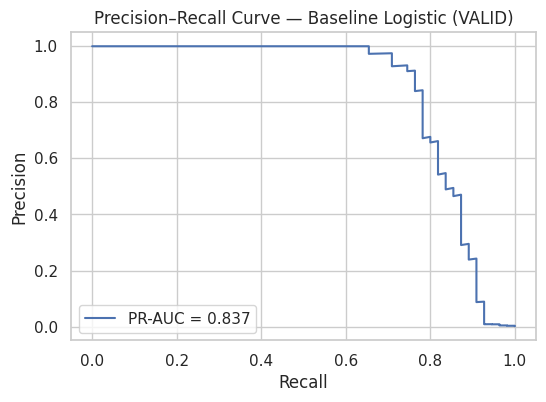

In [17]:
# PR Curve usando função padronizada
_ = plot_pr_curve(
    y_true=y_valid,
    proba=valid_proba,
    title="Precision–Recall Curve — Baseline Logistic (VALID)",
    savepath=PLOTS_FOLDER / "pr_curve_baseline_valid.png",
)

In [18]:
# Tabela de thresholds
threshold_df = make_threshold_table(y_valid, valid_proba)

# F1
threshold_df["f1"] = 2 * (
    threshold_df["precision"] * threshold_df["recall"]
) / (threshold_df["precision"] + threshold_df["recall"]).replace(0, np.nan)

> F1 é fornecido apenas como referência; a política é baseada em recall/precision.

In [19]:
# Cálculo de alertas
threshold_df["alerts"] = (valid_proba.reshape(-1, 1) >= thresholds).sum(axis=0)
threshold_df["alert_rate"] = threshold_df["alerts"] / len(valid_df)

In [20]:
# Seleção de candidatos e política explícita
candidates = threshold_df[threshold_df["precision"] >= MIN_PRECISION]

if candidates.empty:
    raise ValueError(
        f"Nenhum threshold atende precision >= {MIN_PRECISION}. "
        "Ajuste MIN_PRECISION ou revise o modelo."
    )

In [21]:
candidates.sort_values(
    by=["recall", "precision"],
    ascending=[False, False]
).head(10)

,threshold,precision,recall,f1,alerts,alert_rate
41619,0.912264,0.242718,0.909091,0.383142,206,0.004840
41618,0.911549,0.241546,0.909091,0.381679,207,0.004864
41617,0.909661,0.240385,0.909091,0.380228,208,0.004887
41616,0.909578,0.239234,0.909091,0.378788,209,0.004911
41615,0.909439,0.238095,0.909091,0.377358,210,0.004934
41614,0.909255,0.236967,0.909091,0.375940,211,0.004958
41613,0.908783,0.235849,0.909091,0.374532,212,0.004981
41612,0.908752,0.234742,0.909091,0.373134,213,0.005005
41611,0.908683,0.233645,0.909091,0.371747,214,0.005028
41610,0.908559,0.232558,0.909091,0.370370,215,0.005052


In [22]:
# Escolha do threshold
best_row = candidates.sort_values(by=["recall", "precision"], ascending=[False, False]).iloc[0]
best_threshold = float(best_row["threshold"])

In [23]:
# Avaliação com o threshold escolhido
valid_pred_best = (valid_proba >= best_threshold).astype(int)
prec_best = precision_score(y_valid, valid_pred_best, zero_division=0)
rec_best  = recall_score(y_valid, valid_pred_best, zero_division=0)
f1_best   = f1_score(y_valid, valid_pred_best, zero_division=0)
cm_best   = confusion_matrix(y_valid, valid_pred_best)

In [24]:
print(f"Threshold escolhido: {best_threshold:.4f}")
print(f"Precision: {prec_best:.4f}")
print(f"Recall   : {rec_best:.4f}")
print(f"F1       : {f1_best:.4f}")

Threshold escolhido: 0.9123
Precision: 0.2427
Recall   : 0.9091
F1       : 0.3831


In [25]:
print("Confusion Matrix:\n", cm_best)

Confusion Matrix:
 [[42348   156]
 [    5    50]]


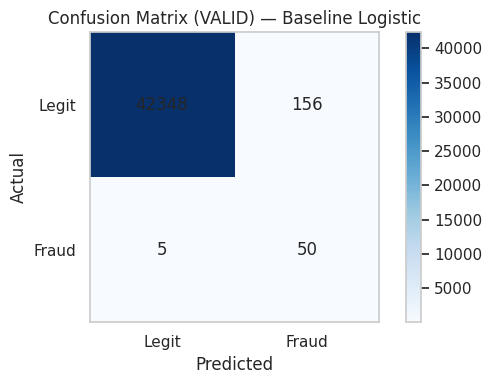

In [26]:
# Confusion Matrix no threshold escolhido pela política
plot_confusion(
    cm = cm_best,
    title="Confusion Matrix (VALID) — Baseline Logistic",
    savepath=PLOTS_FOLDER / "cm_baseline_valid.png",
)

In [27]:
# Salvar tabela de threshold
threshold_df.to_parquet(ANALYSIS_FOLDER/ "threshold_analysis.parquet", index=False)

In [28]:
# Salvar métricas do baseline
baseline_metrics = {
    "model": "LogisticRegression",
    "pr_auc_valid": pr_auc_valid,
    "threshold_policy": f"max_recall_with_precision>={MIN_PRECISION}",
    "chosen_threshold": best_threshold,
    "precision_valid": prec_best,
    "recall_valid": rec_best,
    "f1_valid": f1_best,
    "confusion_matrix_valid": cm_best.tolist(),
}

with open(BASELINE_METRICS, "w", encoding="utf-8") as f:
    json.dump(baseline_metrics, f, indent=2)

In [29]:
# Salvar modelo
joblib.dump(baseline_pipe, MODELS_FOLDER / "baseline_logreg.pkl")

['/home/jhonathan/sdl/POC/fraudwacth/models/baseline_logreg.pkl']

### Resumo da Avaliação

O score contínuo gerado pelo modelo baseline é convertido em uma política explícita de decisão por meio da análise de thresholds no conjunto de validação.

A escolha do threshold prioriza alto recall para a classe de fraude, respeitando uma precisão mínima previamente definida, de forma a equilibrar cobertura de eventos fraudulentos e volume de alertas gerados.

A análise da matriz de confusão indica redução significativa no número de falsos positivos em relação ao threshold padrão, mantendo boa cobertura das fraudes.

Esse trade-off define o comportamento operacional do baseline e estabelece um ponto de referência claro para a evolução do modelo.

## Encerramento

Este notebook consolida o baseline operacional da FraudWatch, contemplando:

- treinamento de um modelo baseline de Regressão Logística atuando como gerador de score contínuo;
- avaliação da capacidade de ordenação de risco por meio da métrica PR-AUC;
- análise do impacto operacional a partir das métricas de classificação;
- definição de uma política explícita de decisão baseada em threshold;
- redução controlada do volume de alertas, mantendo alta cobertura de fraudes;
- persistência dos artefatos do baseline para referência e comparação futura.